In [2]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'roman-pandeia':
    path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

In [3]:
import json
import math
import time
import pickle
import copy
import corner
from datetime import timedelta
from pprint import pprint
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['image.origin'] = 'lower'
import numpy as np
from acstools import acszpt

from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
import astropy.wcs.utils
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D

from pandeia.engine.perform_calculation import perform_calculation
from pandeia.engine.calc_utils import get_telescope_config, get_instrument_config, build_default_calc, build_default_source
from pandeia.engine.io_utils import read_json, write_json

from lenstronomy.LightModel.Profiles.gaussian import GaussianEllipse
gauss = GaussianEllipse()
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Data.psf import PSF
from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman
from lenstronomy.SimulationAPI.ObservationConfig.HST import HST
from lenstronomy.Util import data_util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Data.psf import PSF
from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman
from lenstronomy.Util import data_util
from lenstronomy.Plots import lens_plot
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.SimulationAPI.ObservationConfig.HST import HST

from utils import csv_utils

In [4]:
data_set_name = 'J9OP05010'

# J9OP02010 - complete 1
# J9EM25AFQ - complete 1
# J9OP04010 - complete 1
# J9OP05010 - 
# J9EM0SEEQ - 
# J9OP06010 - 

oversample_factor = 1

Grab lens metadata (dataset)

In [5]:
csv_filepath = os.path.join(repo_path, 'data', 'SLACS', 'SLACS.csv')
dataset_dict_list = csv_utils.csv_to_dict_list(csv_filepath)

dataset = [d for d in dataset_dict_list if d.get('data_set_name') == data_set_name][0]

target_name = dataset.get('target_name')

pprint(dataset)

{'AI': '0.16',
 'Fiber': '252',
 'Imag': '18.16',
 'L(V555)': '82.3',
 'Le2/LdV': '0.306',
 'Lens': 'A',
 'MJD': '52672',
 'Mph': 'E',
 'Mul': 'S',
 'Name': 'J0330-0020',
 'PA': '109.6',
 'Plate': '810',
 'Re': '1.2',
 'SDSS': '033012.14-002051.9',
 '_DE': '-0.34775',
 '_RA': '52.55058',
 'actual_duration': '2088.0',
 'aper': 'WFC1',
 'b/a': '0.77',
 'central_wavelength': '8045.1587',
 'cutout': '',
 'cutout_filepath': '/data/bwedig/roman-pandeia/data/cutouts/SLACS/cutout_WFC1_CLEAR1L;F814W_J9OP05010.fits',
 'data_set_name': 'J9OP05010',
 'data_uri': 'mast:HST/product/j9op05010_drz.fits',
 'dec': '-0.3477702178823',
 'e_sigma': '21',
 'filename': 'j9op05010_drz.fits',
 'fits_filepath': '/data/bwedig/roman-pandeia/data/mastDownload/SLACS/j9op05010_drz.fits',
 'instrument': 'ACS   ',
 'n_Imag': 'd',
 'n_Lens': ' ',
 'peak_value': '',
 'preview_name': 'J9OP05010',
 'ra': '52.55055272469',
 'recno': '10',
 'release_date': '2006-09-17T08:12:11',
 'sigma': '212',
 'spec': 'CLEAR1L;F814W',
 '

In [6]:
# get position
ra, dec = float(dataset.get('ra')), float(dataset.get('dec'))
print(f'Position (RA/DEC): {ra}/{dec}')

# get redshifts 
z_source, z_lens = float(dataset['zBG']), float(dataset['zFG'])
print(f'Redshifts (lens/source): {z_lens}/{z_source}')

# tell lenstronomy that SIE and SHEAR are at same lens redshift
lens_redshift_list = [z_lens, z_lens]

# get magnitude zero point based on date that image was taken
date = dataset.get('start_time')[:10]
q = acszpt.Query(date=date, detector="WFC", filt="F814W")
zpt_table = q.fetch()
print(zpt_table)

magnitude_zero_point = float(zpt_table['ABmag'].value)

Position (RA/DEC): 52.55055272469/-0.3477702178823
Redshifts (lens/source): 0.3507/1.0709
Filter PHOTLAM             PHOTFLAM            STmag  VEGAmag  ABmag 
       Angstrom erg / (Angstrom cm2 electron) mag(ST)   mag   mag(AB)
------ -------- ----------------------------- ------- ------- -------
 F814W   8045.2                    7.1299e-20  26.767  25.501  25.932


Import modeled lenstronomy parameters from macromodel fitting notebook

In [7]:
modeled_lenses_dir = os.path.join(repo_path, 'data', 'modeled_lenses')

with open(os.path.join(modeled_lenses_dir, data_set_name + '_lens'), 'rb') as lens_file:
    kwargs_lens = pickle.load(lens_file)

with open(os.path.join(modeled_lenses_dir, data_set_name + '_lens_light'), 'rb') as lens_light_file:
     kwargs_lens_light = pickle.load(lens_light_file)

with open(os.path.join(modeled_lenses_dir, data_set_name + '_source'), 'rb') as source_file:
     kwargs_source_light = pickle.load(source_file)

pprint(kwargs_lens)
print('-------------------')
pprint(kwargs_lens_light)
print('-------------------')
pprint(kwargs_source_light)

[{'center_x': 0.021191140869218455,
  'center_y': 0.23653602168175367,
  'e1': 0.2380927078131898,
  'e2': -0.07677946553947183,
  'theta_E': 1.2080323034290816},
 {'dec_0': 0.0,
  'gamma1': 0.1323126691692451,
  'gamma2': -0.03846973126999553,
  'ra_0': 0.0}]
-------------------
[{'R_sersic': 1.2382535258480538,
  'amp': 30.455294863155636,
  'center_x': -0.04483469962154317,
  'center_y': 0.14690607690197205,
  'e1': 0.11932999294723581,
  'e2': -0.07877826329248758,
  'n_sersic': 4.998922801824989}]
-------------------
[{'R_sersic': 0.41196561267519477,
  'amp': 12.742185449771469,
  'center_x': 0.1457514391494612,
  'center_y': 0.7475111579374039,
  'e1': -0.060481291976515125,
  'e2': -0.05238772463822375,
  'n_sersic': 4.9986046463928915}]


Set up lenstronomy classes and kwarg dicts

In [8]:
# mass model
lens_model_list = ['SIE', 'SHEAR']
lens_model_class = LensModel(lens_model_list)

# light model
lens_light_model_list = ['SERSIC_ELLIPSE']
lens_light_model_class = LightModel(lens_light_model_list)

# source model
source_model_list = ['SERSIC_ELLIPSE']
source_model_class = LightModel(source_model_list)

kwargs_model = {'lens_model_list': lens_model_list,
                    'lens_light_model_list': lens_light_model_list,
                    'source_light_model_list': source_model_list}

kwargs_psf = {'psf_type': 'NONE'}
psf_class = PSF(**kwargs_psf)

kwargs_numerics = {'supersampling_factor': 4,
                'supersampling_convolution': False}

Convert amplitudes from modeling to actual values

In [9]:
# grab amp values for lens and source from fitting
lens_amp = kwargs_lens_light[0]['amp']
source_amp = kwargs_source_light[0]['amp']
ratio_amp_lens_to_source = lens_amp / source_amp
print(f'Amplitudes from fitting (lens/source): {lens_amp}/{source_amp}')

# set up new kwargs in terms of magnitude for conversion
kwargs_lens_light_mag = copy.deepcopy(kwargs_lens_light)
kwargs_source_light_mag = copy.deepcopy(kwargs_source_light)
del kwargs_lens_light_mag[0]['amp']
del kwargs_source_light_mag[0]['amp']

# set magnitude of lens based on number from paper
source_magnitude = float(dataset.get('Imag'))
print(f'Lens magnitude from paper: {source_magnitude}')
kwargs_lens_light[0]['magnitude'] = source_magnitude

# use this value to convert to correct amplitude
kwargs_lens_light_amp = data_util.magnitude2amplitude(lens_light_model_class, kwargs_lens_light, magnitude_zero_point)

# get new kwargs in terms of amplitude for source
kwargs_source_light_amp = copy.deepcopy(kwargs_source_light)

# scale source light appropriately (this amp parameter is linear)
lens_amp_corrected = kwargs_lens_light_amp[0]['amp']
source_amp_corrected = lens_amp_corrected / ratio_amp_lens_to_source
kwargs_source_light_amp[0]['amp'] = source_amp_corrected
print(f'Corrected amplitudes based on lens magnitude from paper (lens/source): {lens_amp_corrected}/{source_amp_corrected}')

Amplitudes from fitting (lens/source): 30.455294863155636/12.742185449771469
Lens magnitude from paper: 18.16
Corrected amplitudes based on lens magnitude from paper (lens/source): 33.18441776037567/13.884022697706493


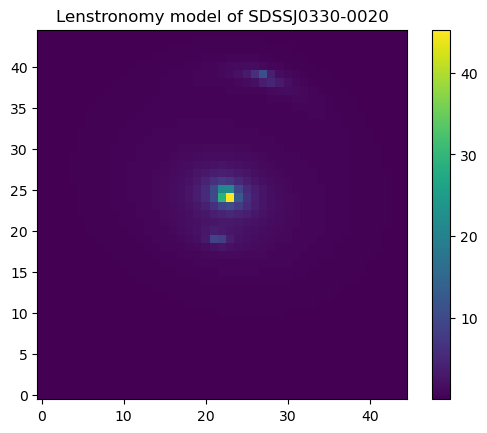

In [10]:
side = 5  # arcseconds
num_pix = 45 * oversample_factor
delta_pix = side / num_pix  # size of pixel in angular coordinates

ra_at_xy_0, dec_at_xy_0 = -delta_pix * math.ceil(num_pix / 2), -delta_pix * math.ceil(num_pix / 2) # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * delta_pix  # linear translation matrix of a shift in pixel in a shift in coordinates

kwargs_pixel = {'nx': num_pix, 'ny': num_pix,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)

imageModel = ImageModel(data_class=pixel_grid,
                        psf_class=psf_class,
                        lens_model_class=lens_model_class,
                        source_model_class=source_model_class,
                        lens_light_model_class=lens_light_model_class,
                        kwargs_numerics=kwargs_numerics)

image = imageModel.image(kwargs_lens=kwargs_lens,
                        kwargs_source=kwargs_source_light_amp,
                        kwargs_lens_light=kwargs_lens_light_amp)

# correct for spreading counts across more pixels TODO CONFIRM THIS
image = image / (oversample_factor ** 2)

plt.imshow(np.log10(image))
plt.title(f'Lenstronomy model of {target_name}')
# plt.savefig(os.path.join('figures', 'pixel_density_test', 'model_' + str(oversample_factor) + '.png'))
plt.colorbar()
plt.show()

model_array_path = os.path.join(repo_path, 'arrays', 'SLACS', data_set_name + '_hst_counts_' + str(oversample_factor) + '.npy')
np.save(model_array_path, image)

Create lens plot with caustics, positions, etc.

0.1457514391494612 0.7475111579374039
[ 3.31522386 -1.82923445]


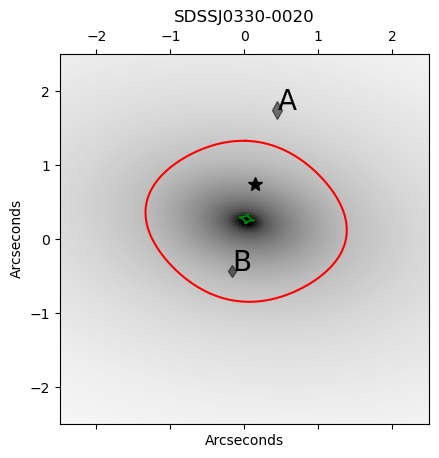

In [11]:
# source plane coordinates of source
beta_ra, beta_dec = kwargs_source_light[0]['center_x'], kwargs_source_light[0]['center_y']
print(beta_ra, beta_dec)

# specify the lens model class to deal with
solver = LensEquationSolver(lens_model_class)

# solve for image positions provided a lens model and the source position
theta_ra, theta_dec = solver.image_position_from_source(beta_ra, beta_dec, kwargs_lens)

# the magnification of the point source images
mag = lens_model_class.magnification(theta_ra, theta_dec, kwargs_lens)
print(mag)

# plot
f, axes = plt.subplots()
lens_plot.lens_model_plot(axes, lensModel=lens_model_class, kwargs_lens=kwargs_lens, sourcePos_x=beta_ra, sourcePos_y=beta_dec, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=False)
axes.set_title(dataset.get('target_name'))
axes.set_xlabel('Arcseconds')
axes.set_ylabel('Arcseconds')
f.show()
f.savefig(os.path.join(repo_path, 'figures', 'lenstronomy_modeling', data_set_name + '_caustics.png'))

Get original Hubble image

Filename: /data/bwedig/roman-pandeia/data/cutouts/SLACS/cutout_WFC1_CLEAR1L;F814W_J9OP05010.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      91   (300, 300)   float32   
Drizzle, pixel size (arcsec) of output image: 0.05


/tmp/ipykernel_13892/1471168152.py:24: RuntimeWarning: invalid value encountered in log10
  ax.imshow(np.log10(data), cmap='cividis')


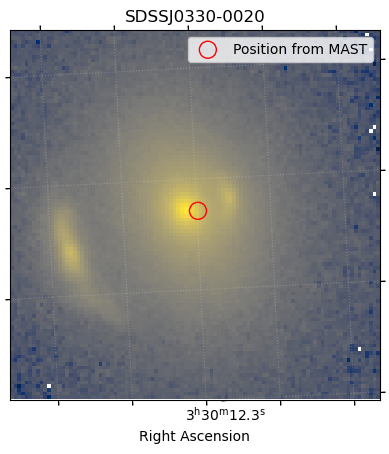

In [12]:
with fits.open(dataset.get('cutout_filepath')) as hdu_list:
    hdu_list.verify()
    hdu_list.info()
    data = hdu_list['PRIMARY'].data
    header = hdu_list['PRIMARY'].header

drizzle_pixel_size = header.get('D001SCAL')
print(f'Drizzle, pixel size (arcsec) of output image: {drizzle_pixel_size}')

wcs = WCS(header=hdu_list['PRIMARY'].header)

sky_coords = SkyCoord(ra, dec, unit='deg', frame='icrs')
size = u.Quantity((5, 5), u.arcsec)
cutout_obj = Cutout2D(data, sky_coords, size, wcs=wcs)

# overwrite data and wcs
data = cutout_obj.data
wcs = cutout_obj.wcs

center_pixel_y, center_pixel_x = wcs.all_world2pix(ra, dec, 1, adaptive=False, ra_dec_order=True)

ax = plt.subplot(projection=wcs)
ax.imshow(np.log10(data), cmap='cividis')
plt.grid(color='white', ls=':', alpha=0.2)
# plt.scatter(center_pixel_x, center_pixel_y, edgecolor='red', facecolor='none', s=150, label='Position from MAST')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.title(dataset.get('target_name'))
# plt.legend()
plt.show()

Create a Hubble image (`lenstronomy` can only do WFC3 F160W whereas my data is from WFC1 F814W, but eh)

HST's pixel scale: 0.08


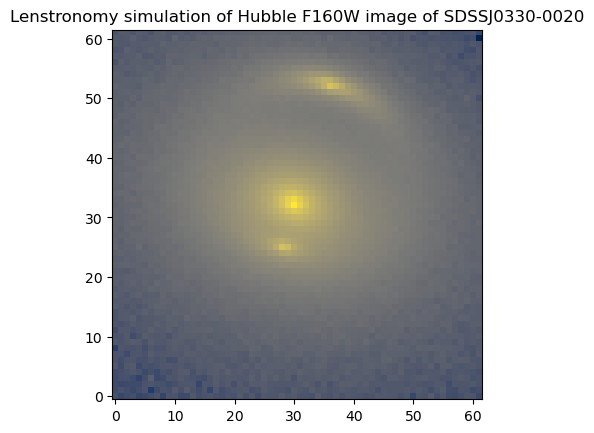

In [13]:
HST_wfc3_f160w = HST(band='WFC3_F160W', psf_type='GAUSSIAN', coadd_years=None)

kwargs_wfc3_f160w = HST_wfc3_f160w.kwargs_single_band()

hst_pixel_scale = HST_wfc3_f160w.kwargs_single_band().get('pixel_scale')
print(f'HST\'s pixel scale: {hst_pixel_scale}')

hst_num_pix = int(5 / hst_pixel_scale)

sim_wfc3_f160w = SimAPI(numpix=hst_num_pix, kwargs_single_band=kwargs_wfc3_f160w, kwargs_model=kwargs_model)

imSim_kwargs_wfc3_f160w = sim_wfc3_f160w.image_model_class(kwargs_numerics)

image_wfc3_f160w = imSim_kwargs_wfc3_f160w.image(kwargs_lens=kwargs_lens, kwargs_lens_light=kwargs_lens_light_amp, kwargs_source=kwargs_source_light_amp)

image_wfc3_f160w += sim_wfc3_f160w.noise_for_model(model=image_wfc3_f160w)

hst_image = np.zeros((image_wfc3_f160w.shape[0], image_wfc3_f160w.shape[1], 1), dtype=float)
hst_image[:,:,0] = plot_util.sqrt(image_wfc3_f160w, scale_min=0, scale_max=10000)

plt.imshow(np.log10(hst_image), aspect='equal', cmap='cividis')
plt.title(f'Lenstronomy simulation of Hubble F160W image of {target_name}')
plt.show()

Load `lenstronomy` model

In [14]:
model = np.load(model_array_path)

Convert model from counts per time per square angle (lenstronomy default) to magnitude

100%|██████████| 45/45 [00:00<00:00, 12204.57it/s]


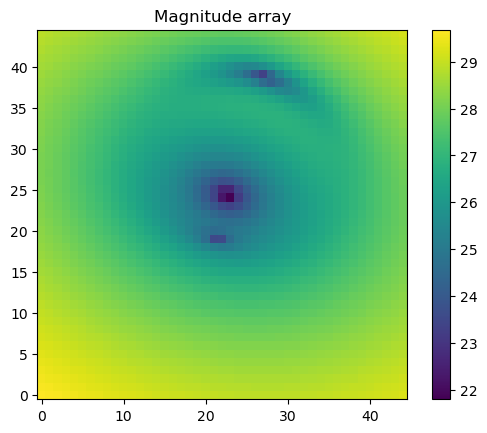

In [15]:
i = 0
side, _ = model.shape

mag_array = np.zeros(model.shape)

for row_number, row in tqdm(enumerate(model), total=side):
    for item_number, item in enumerate(row):
        mag_array[row_number][item_number] = data_util.cps2magnitude(item, magnitude_zero_point)
        i += 1

plt.imshow(mag_array)
plt.title('Magnitude array')
plt.colorbar()
plt.show()

Build Pandeia input file

In [16]:
calc = build_default_calc('roman','wfi','imaging')

# don't allow scene size to change
calc['configuration']['dynamic_scene'] = True
calc['configuration']['max_scene_size'] = 5

# change filter
calc['configuration']['instrument']['filter'] = 'f106'

# adjust brightness (np.interp for now)
max = np.max(model)
min = np.min(model)
model = np.interp(model, (min, max), (0.00001, 0.001))

In [17]:
i = 0

print('Converting to point sources...')
for row_number, row in tqdm(enumerate(mag_array), total=side):
    for item_number, item in enumerate(row):
        if i != 0:
            calc['scene'].append(build_default_source(geometry="point"))

        # set brightness
        calc['scene'][i]['spectrum']['normalization']['type'] = 'hst'
        calc['scene'][i]['spectrum']['normalization']['bandpass'] = 'acs,wfc1,f814w'
        calc['scene'][i]['spectrum']['normalization']['norm_flux'] = item
        calc['scene'][i]['spectrum']['normalization']['norm_fluxunit'] = 'abmag'
        
        # set position
        calc['scene'][i]['position']['x_offset'] = (item_number * (1 / 9) * (1 / oversample_factor)) + ra_at_xy_0  # arcsec
        calc['scene'][i]['position']['y_offset'] = (row_number * (1 / 9) * (1 / oversample_factor)) + dec_at_xy_0  # arcsec

        i += 1
print('Point source conversion complete')

Converting to point sources...


100%|██████████| 45/45 [00:11<00:00,  4.08it/s]

Point source conversion complete


In [18]:
print('Performing Pandeia calculation...')
results = perform_calculation(calc)
print('Pandeia calculation complete')

detector = results['2d']['detector']

Performing Pandeia calculation...


Pandeia calculation complete


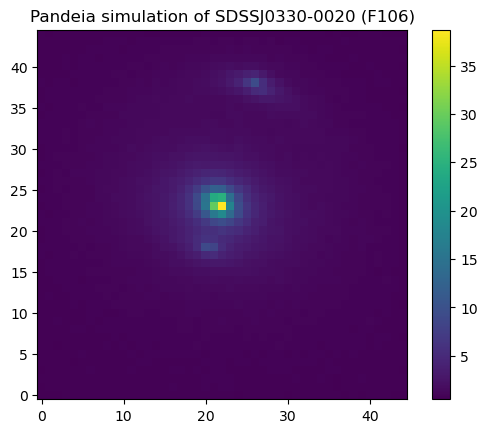

In [19]:
# TODO TEMP! flip image
detector = np.flipud(detector)
# detector = np.fliplr(detector)

plt.imshow(detector)
plt.title(f'Pandeia simulation of {target_name} (F106)')
plt.savefig(os.path.join(repo_path, 'figures', 'SLACS', data_set_name + '_pandeia_' + str(oversample_factor) + '.png'))
plt.colorbar()
plt.show()

In [20]:
# save this numpy array
pandeia_array_path = os.path.join(repo_path, 'arrays', 'SLACS', data_set_name + '_pandeia_' + str(oversample_factor) + '.npy')
np.save(pandeia_array_path, detector)